## Imports and Setup

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "okcupid-stem"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = True

<ipython-input-38-e292a8bbb081>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [39]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Datasets

In [41]:
from openml.datasets import get_dataset

did = 41440

dataset = get_dataset(did)

print(f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)

This is dataset 'okcupid-stem', the target feature is 'job'


In [42]:
target = dataset.default_target_attribute
df, _, categorical_indicator, attribute_names = dataset.get_data(dataset_format="dataframe")

In [43]:
print(df.shape)
df.head(10)

(50789, 20)


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,job
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,NaN,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single,non_stem
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single,non_stem
2,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single,student
3,29,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,NaN,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single,non_stem
4,29,average,mostly anything,socially,NaN,graduated from college/university,white,67.0,NaN,"san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single,stem
5,31,average,mostly anything,socially,never,graduated from college/university,white,65.0,NaN,"san francisco, california","doesn&rsquo;t have kids, but wants them",straight,likes dogs and likes cats,christianity,f,sagittarius,no,"english, spanish (okay)",single,non_stem
6,37,athletic,mostly anything,not at all,never,working on two-year college,white,65.0,NaN,"san mateo, california",NaN,straight,likes dogs and likes cats,atheism and laughing about it,m,cancer but it doesn&rsquo;t matter,no,english (fluently),single,student
7,28,average,mostly anything,socially,never,graduated from college/university,white,72.0,40000,"daly city, california",NaN,straight,likes cats,christianity and very serious about it,m,leo but it doesn&rsquo;t matter,no,"english (fluently), sign language (poorly)",seeing someone,non_stem
8,24,NaN,NaN,often,NaN,NaN,white,72.0,NaN,"san francisco, california",doesn&rsquo;t have kids,straight,NaN,other,m,taurus,NaN,english,single,non_stem
9,30,skinny,mostly anything,socially,never,graduated from high school,white,66.0,30000,"san francisco, california",NaN,straight,has dogs and likes cats,christianity but not too serious about it,f,NaN,no,english,single,non_stem


## Clean and EDA

###Target

In [44]:
# drop rows with target=='student'
df = df.loc[df[target]!="student"].copy()
# reset category levels in target
df[target] = pd.Categorical(df[target], df[target].unique().tolist() )

###Features

In [45]:
def eda_cat(df, feature, target, save=False, show=True):

    # convert NaN to "NaN"
    if df[feature].isna().sum()>0:
        df[feature] = df[feature].cat.add_categories("NaN").fillna("NaN")

    # create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

    # bar plot to show counts
    df_ct = pd.crosstab(df[feature], df[target], dropna=False, margins=True)[:-1]
    df_ct.sort_values("All", ascending=False, inplace=True)
    df_ct['All'].plot(kind='barh', stacked=True, ax=axs[0])
    axs[0].set_title("counts")

    # normalised stacked barplot to show breakdown
    df_ct = df_ct.iloc[:,:-1].div(df_ct.All, axis=0)
    df_ct.plot(kind='barh', stacked=True, ax=axs[1])
    axs[1].legend(bbox_to_anchor=(1,1), facecolor='gray', framealpha=1)
    axs[1].set_title(f"breakdown wrt {target}")

    plt.suptitle(f"Feature {feature} - Count plot and breakdown wrt {target}")

    if save:
        filename = save if type(save)==str else feature
        plt.savefig(f"output/{filename}.png", bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [46]:
cat_features = set()
num_features = set()

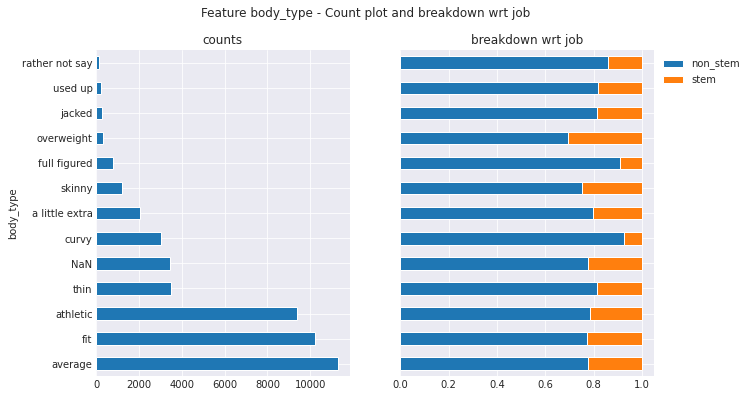

In [47]:
eda_cat(df, "body_type", target)

###Categorical features

####Body type

In [48]:
feature = "body_type"

In [50]:
criteria = df[feature].isin(["rather not say", "used up"]) 
df.loc[criteria, feature] = "NaN"

In [51]:
criteria = df[feature]=="a little extra"
df.loc[criteria, feature] = "overweight"

In [52]:
criteria = df[feature]=="jacked"
df.loc[criteria, feature] = "fit"

In [53]:
criteria = df[feature]=="full figured"
df.loc[criteria, feature] = "curvy"

In [54]:
df[feature].cat.categories

Index(['a little extra', 'athletic', 'average', 'curvy', 'fit', 'full figured',
       'jacked', 'overweight', 'rather not say', 'skinny', 'thin', 'used up',
       'NaN'],
      dtype='object')

In [55]:
df[feature] = pd.Categorical(df[feature].astype(str))

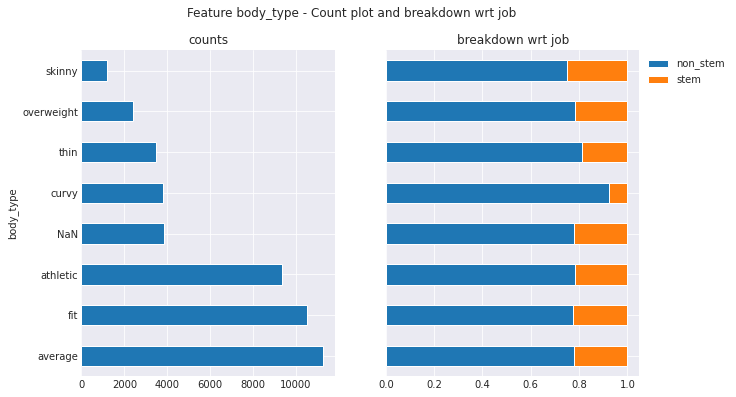

In [56]:
eda_cat(df, feature, target)

####Diet

In [57]:
feature = "diet"

In [58]:
criteria = df[feature].isin(["strictly vegetarian", "halal", "kosher", "strictly halal", "strictly kosher", "mostly halal", "mostly kosher", "vegan", "strictly vegan",
                         "mostly vegan", "other", "strictly other"])
df.loc[criteria, feature] = "mostly other"

In [59]:
criteria = df[feature]=="strictly vegetarian"
df.loc[criteria, feature] = "vegetarian"

In [60]:
df[feature].cat.categories

Index(['anything', 'halal', 'kosher', 'mostly anything', 'mostly halal',
       'mostly kosher', 'mostly other', 'mostly vegan', 'mostly vegetarian',
       'other', 'strictly anything', 'strictly halal', 'strictly kosher',
       'strictly other', 'strictly vegan', 'strictly vegetarian', 'vegan',
       'vegetarian'],
      dtype='object')

In [61]:
df[feature] = pd.Categorical(df[feature].astype(str))

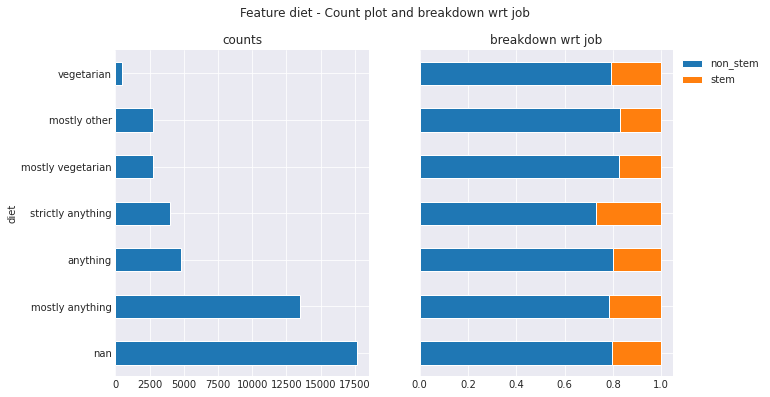

In [62]:
eda_cat(df, feature, target)

####Drinks

In [63]:
feature = "drinks"

In [64]:
criteria = df[feature].isin(["very often", "desperately"])
df.loc[criteria, feature] = "often"

In [65]:
df[feature].cat.categories

Index(['desperately', 'not at all', 'often', 'rarely', 'socially',
       'very often'],
      dtype='object')

In [66]:
df[feature] = pd.Categorical(df[feature].astype(str))

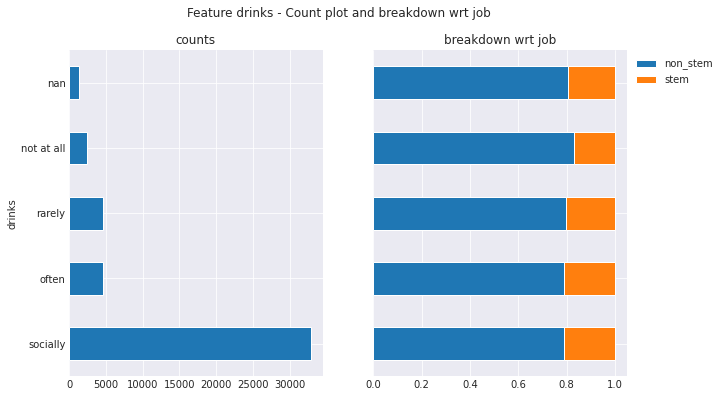

In [67]:
eda_cat(df, feature, target)

####Drugs

In [68]:
feature = "drugs"

In [69]:
criteria = df[feature] == "often"
df.loc[criteria, feature] = "sometimes"

In [70]:
df[feature].cat.categories

Index(['never', 'often', 'sometimes'], dtype='object')

In [71]:
df[feature] = pd.Categorical(df[feature].astype(str))

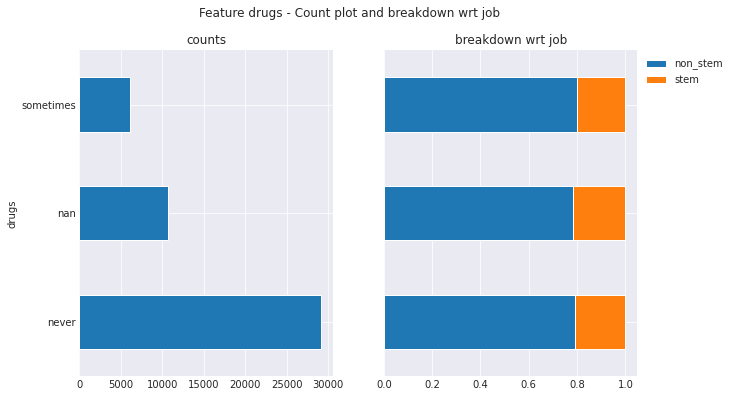

In [72]:
eda_cat(df, feature, target)

####Orientation

In [73]:
feature = "orientation"

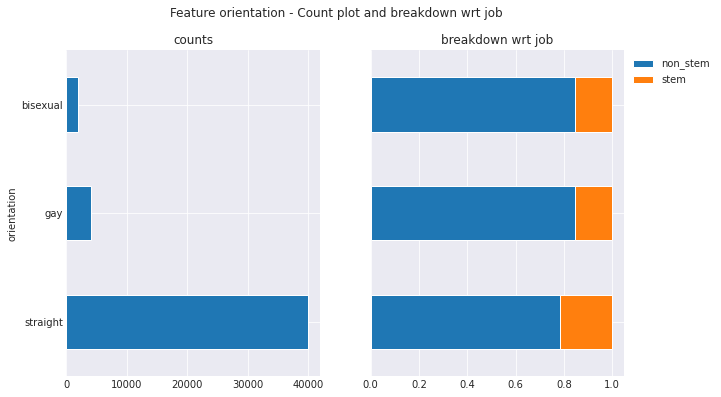

In [74]:
eda_cat(df, feature, target)

####Pets

In [75]:
feature = "pets"

In [86]:
criteria = df[feature].isin(["dislike dogs"])

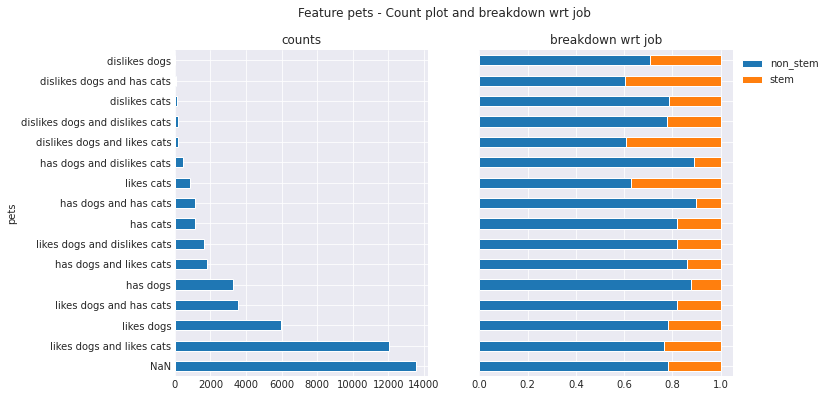

In [76]:
eda_cat(df, feature, target)

####Sex

In [77]:
feature = "sex"

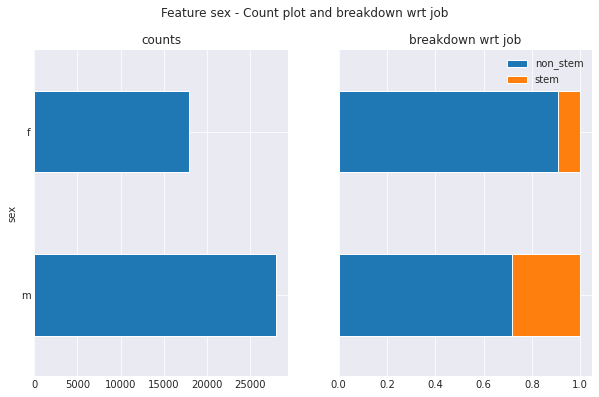

In [78]:
eda_cat(df, feature, target)

####Smokes

In [79]:
feature = "smokes"

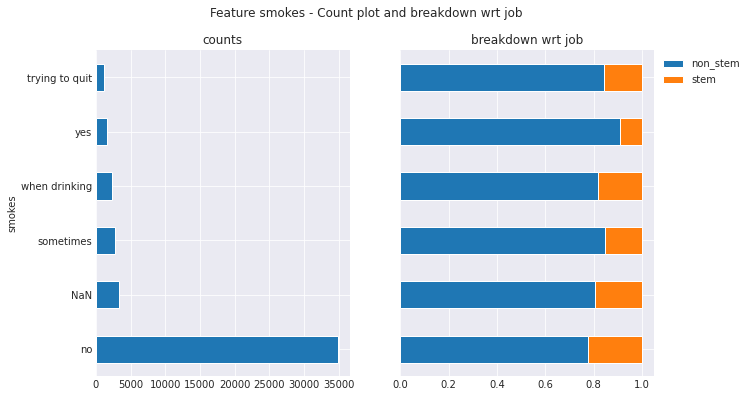

In [80]:
eda_cat(df, feature, target)

####Religion

In [81]:
feature = "religion"

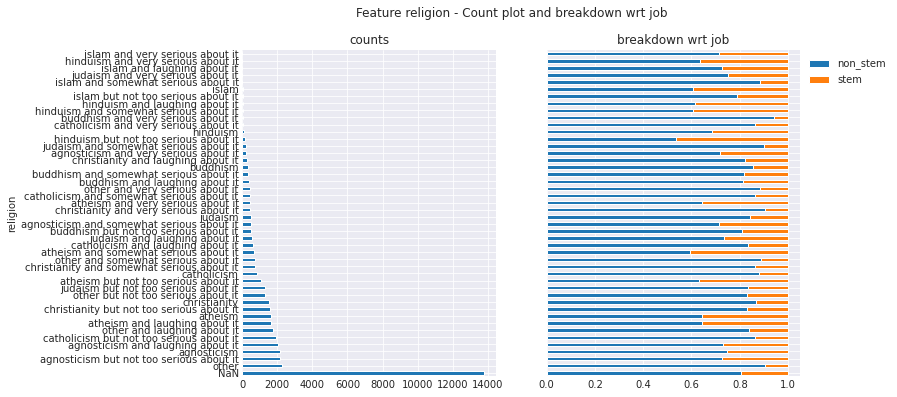

In [82]:
eda_cat(df, feature, target)

####Status

In [83]:
feature = "status"

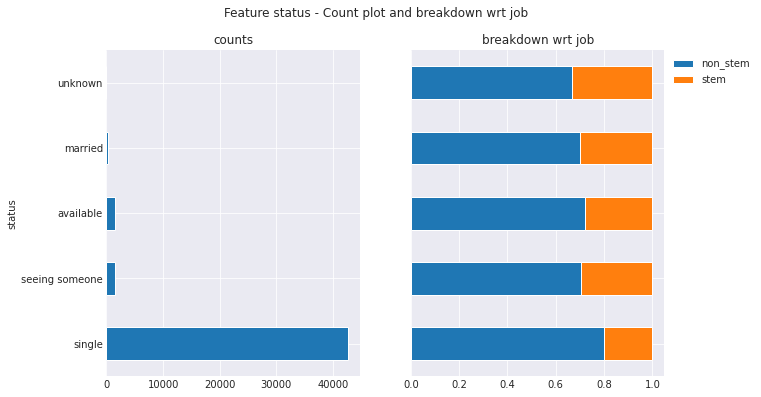

In [84]:
eda_cat(df, feature, target)